In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/RL_Project

/content/drive/.shortcut-targets-by-id/1DX6WdsrsfIdKk_qqfM2A4LadvqllxkhX/RL_Project


In [ ]:
# Restart the session after running this cell (Run it once!)

# !git clone https://github.com/sparisi/gym_gridworlds

!pip install ./gym_gridworlds

Processing ./gym_gridworlds
  Preparing metadata (setup.py) ... done
  Created wheel for Gym-Gridworlds: filename=Gym_Gridworlds-1.0-py3-none-any.whl size=15432 sha256=90187657a36ac895c357512f66427d8cd26bf8812ec87f59a8856af6d00dfe09
  Stored in directory: /tmp/pip-ephem-wheel-cache-cjrmoyg2/wheels/15/a4/c4/18d53e6e8e4a27c1a558dc54d0b7a8c3f0d60e8f838cfb0140
Successfully built Gym-Gridworlds
  Attempting uninstall: Gym-Gridworlds
    Found existing installation: Gym-Gridworlds 1.0
    Uninstalling Gym-Gridworlds-1.0:
      Successfully uninstalled Gym-Gridworlds-1.0


# Import Libraries

In [ ]:
import numpy as np

import torch

import torch.nn as nn

torch._dynamo.config.suppress_errors = True

import torch.optim as optim

import torch.nn.functional as F

import random

from collections import namedtuple, deque

import gym

import gymnasium

from tqdm import trange

import matplotlib.pyplot as plt

import json

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import warnings

warnings.filterwarnings('ignore')

# Network

In [ ]:
class BinaryStepActivation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone() * 0

In [ ]:
# Define the neural network model

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, depth, fc_unit, final_layer_unit):

        super().__init__()

        self.seed = torch.manual_seed(seed)

        self.feature_size = 128

        self.feature_layer = nn.Linear(state_size, self.feature_size)

        # self.hidden_layer = nn.Linear(self.feature_size, self.feature_size)

        self.init_weights(self.feature_layer)

        self.layers = nn.ModuleList()

        for i in range(depth):

            if depth == 1:

                self.layers.append(nn.Linear(self.feature_size, final_layer_unit))

            elif i == 0:

                self.layers.append(nn.Linear(self.feature_size, fc_unit))

            elif i == depth - 1:

                self.layers.append(nn.Linear(fc_unit, final_layer_unit))

            else:

                self.layers.append(nn.Linear(fc_unit, fc_unit))



        for layer in self.layers:

          self.init_weights(layer)



        if depth > 0:

          self.final_layer = nn.Linear(final_layer_unit, action_size)

        else:

          self.final_layer = nn.Linear(self.feature_size, action_size)



        #nn.init.zeros_(self.final_layer.weight)

        #nn.init.zeros_(self.final_layer.bias)

        self.init_weights(self.final_layer)



    def init_weights(self, layer):

        nn.init.xavier_normal(layer.weight)

        self.to(device)



    def forward(self, state):

        x = self.feature_layer(state)
        # x = BinaryStepActivation.apply(x)

        # x = self.hidden_layer(x)
        x = F.relu(x)

        for layer in self.layers:
            x = layer(x)

        return self.final_layer(x)


# ReplayBuffer

In [ ]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size

        self.memory = deque(maxlen=buffer_size)

        self.batch_size = batch_size

        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

        self.seed = random.seed(seed)



    def add(self, state, action, reward, next_state, done):

        e = self.experience(state, action, reward, next_state, done)

        self.memory.append(e)



    def sample(self):

        experiences = random.sample(self.memory, k=self.batch_size)



        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)

        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)

        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)

        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)

        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)



        return (states, actions, rewards, next_states, dones)



    def __len__(self):

        return len(self.memory)

# DQN

In [ ]:
# Define the DQN agent class

class DQNAgent:

    # Initialize the DQN agent

    def __init__(self, state_size, action_size, seed, lr, network):

        self.state_size = state_size

        self.action_size = action_size

        self.seed = random.seed(seed)



        self.qnetwork_local = QNetwork(state_size, action_size, seed, network["depth"], network["fc_units"], network["final_fc_units"]).to(device)

        self.qnetwork_target = QNetwork(state_size, action_size, seed, network["depth"], network["fc_units"], network["final_fc_units"]).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)



        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)

        self.t_step = 0



    def step(self, state, action, reward, next_state, done):

        self.memory.add(state, action, reward, next_state, done)



        self.t_step = (self.t_step + 1) % 4

        if self.t_step == 0:

            if len(self.memory) > 64:

                experiences = self.memory.sample()

                self.learn(experiences, gamma=0.99)



    # Choose an action based on the current state

    def act(self, state, eps=0.):

        #print(state)

        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.qnetwork_local.eval()

        with torch.no_grad():

            action_values = self.qnetwork_local(state_tensor)

        self.qnetwork_local.train()



        if np.random.random() > eps:

            return action_values.argmax(dim=1).item()

        else:

            return np.random.randint(self.action_size)



    # Learn from batch of experiences

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.from_numpy(np.vstack(states)).float().to(device)

        actions = torch.from_numpy(np.vstack(actions)).long().to(device)

        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)

        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)

        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)



        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))



        Q_expected = self.qnetwork_local(states).gather(1, actions)



        loss = F.mse_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()

        loss.backward()

        self.optimizer.step()



        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)



        return loss



    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):

            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

# Hyperparameters

In [ ]:
num_episodes = 1500

max_steps_per_episode_train = 150

#max_steps_per_episode_eval = 25

epsilon_start = 0.9

epsilon_end = 0.05

epsilon_decay_rate = 0.90
# epsilon_decay_rate = 0.001


gamma = 0.99

lr = 1e-4

buffer_size = 10000

batch_size = 128

update_frequency = 3

test_episodes = 1

# Setup Environment

In [ ]:
#env_id = "Gym-Gridworlds/DangerMaze-6x6-v0"

#env_id = "Gym-Gridworlds/Empty-10x10-v0"

#env_id = "Gym-Gridworlds/Penalty-3x3-v0"

#env = gymnasium.make(env_id, render_mode="binary")

#env_eval = gymnasium.make(env_id, max_episode_steps=max_steps_per_episode_eval, render_mode="binary")

env = gym.make('Acrobot-v1')

env_eval = gym.make('Acrobot-v1')

# DQN Agent

In [ ]:
input_dim = env.observation_space.shape[0]

output_dim = env.action_space.n

#depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]

#fc_units = [500, 366, 262, 215, 187, 168, 153, 142, 133, 125, 87, 54]

#final_units = [500, 366, 263, 217, 188, 165, 157, 144, 134, 135, 75, 54]

depths = [1]

fc_units = [128]

final_units = [128]

networks = [QNetwork(input_dim, output_dim, seed=i, depth=depths[i], fc_unit=fc_units[i], final_layer_unit=final_units[i]) for i in range(len(depths))]

netwrok_names = [f"DQN_{depths[i]:02}_{fc_units[i]}_{sum(p.numel() for p in networks[i].parameters())}" for i in range(len(depths))]

data = {}

for network in networks:

  data[network] = {"loss": [], "train_reward": [], "eval_reward": []}



netwrok_names

['DQN_01_128_17795']

In [ ]:
for net in networks:
  print(net)

QNetwork(
  (feature_layer): Linear(in_features=6, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (final_layer): Linear(in_features=128, out_features=3, bias=True)
)


# Evaluation

In [ ]:
def eval(new_agent):

  episode_rewards = []



  action_series = []

  for episode in range(test_episodes):

      action_series.append([])

      state = env_eval.reset()

      episode_reward = 0

      done = False

      while not done:

          action = new_agent.act(state, eps=0.)

          next_state, reward, done, _ = env_eval.step(action)
          #done = term or trunc

          action_series[-1].append(action)

          episode_reward += reward

          state = next_state



      episode_rewards.append(episode_reward)





  average_reward = sum(episode_rewards) / test_episodes

  return average_reward, action_series

# Training

In [ ]:
for seed in range(3):

  print(f"seed = {seed}")

  for i, network in enumerate(networks):

    if i not in [0]:

      continue



    buffer = deque(maxlen=buffer_size)



    new_agent = DQNAgent(input_dim, output_dim, seed=seed, lr = lr, network={"depth": depths[i], "fc_units": fc_units[i], "final_fc_units": final_units[i]})



    # Training



    losses = []

    rewards = []

    average_rewards = []



    ep_mean_reward = 0

    ep_mean_reward_fixed = 0

    ep_mean_loss = 0

    epsilon = epsilon_start



    pbar = trange(num_episodes, position=0, leave=True, desc=f"{netwrok_names[i]}", unit="episode")



    for episode in pbar:

        # Reset the environment

        state = env.reset()

        epsilon = max(epsilon_end, epsilon * epsilon_decay_rate)

        ep_reward = 0

        ep_loss = 0

        #print(state)

        # Run one episode

        for step in range(max_steps_per_episode_train):

            # Choose and perform an action

            action = new_agent.act(state, epsilon)

            next_state, reward, done, _ = env.step(action)
            #done = term or trunc

            #if reward > 0:

            #  print("REWARDDDDDD!")

            buffer.append((state, action, reward, next_state, done))



            #print(len(buffer), batch_size)

            if len(buffer) >= batch_size:

                batch = random.sample(buffer, batch_size)

                # Update the agent's knowledge

                loss = new_agent.learn(batch, gamma)

                ep_loss += loss



            state = next_state



            ep_reward += reward

            # Check if the episode has ended

            if done:

              #print("H")

              break



        rewards.append(ep_reward)

        ep_mean_reward += ep_reward

        if episode % update_frequency == 0:

          ep_mean_reward_fixed = ep_mean_reward

          average_reward, action_series = eval(new_agent)

          ep_mean_reward = 0



        #if episode % (update_frequency * update_frequency) == 0:

        #  eval_Q_plot(new_agent)

          #print(action_series)



        average_rewards.append(average_reward)



        if type(ep_loss) == int:

          record = 0

          pbar.set_postfix(loss=ep_loss, ep_reward=average_reward, train_reward=ep_reward, epsilon=epsilon)

          losses.append(ep_loss)

        else:

          record = 1

          pbar.set_postfix(loss=ep_loss.item(), ep_reward=average_reward, train_reward=ep_reward, epsilon=epsilon)

          losses.append(ep_loss.detach().cpu())



    data[network]["eval_reward"].append(average_rewards)

    if record == 1:

      data[network]["loss"].append(losses)

    data[network]["train_reward"].append(rewards)



    to_be_saved = {"loss": np.array(losses).tolist(), "train_reward": rewards, "eval_reward": average_rewards}

    with open(f"Acrobat_{netwrok_names[i][:7]}{seed}_binarystep.json", "w") as f:
      json.dump(to_be_saved, f)

seed = 0


DQN_01_128_17795: 100%|██████████| 1500/1500 [12:19<00:00,  2.03episode/s, ep_reward=-83, epsilon=0.05, loss=191, train_reward=-133]


seed = 1


DQN_01_128_17795: 100%|██████████| 1500/1500 [12:20<00:00,  2.03episode/s, ep_reward=-78, epsilon=0.05, loss=126, train_reward=-90]


seed = 2


DQN_01_128_17795: 100%|██████████| 1500/1500 [12:18<00:00,  2.03episode/s, ep_reward=-110, epsilon=0.05, loss=125, train_reward=-96]


In [ ]:
# average_rewards

# Visualization

In [ ]:
# with open(f"Acrobat_{netwrok_names[i][:7]}{seed}_ReLU.json", "w") as f:

#       json.dump(to_be_saved, f)

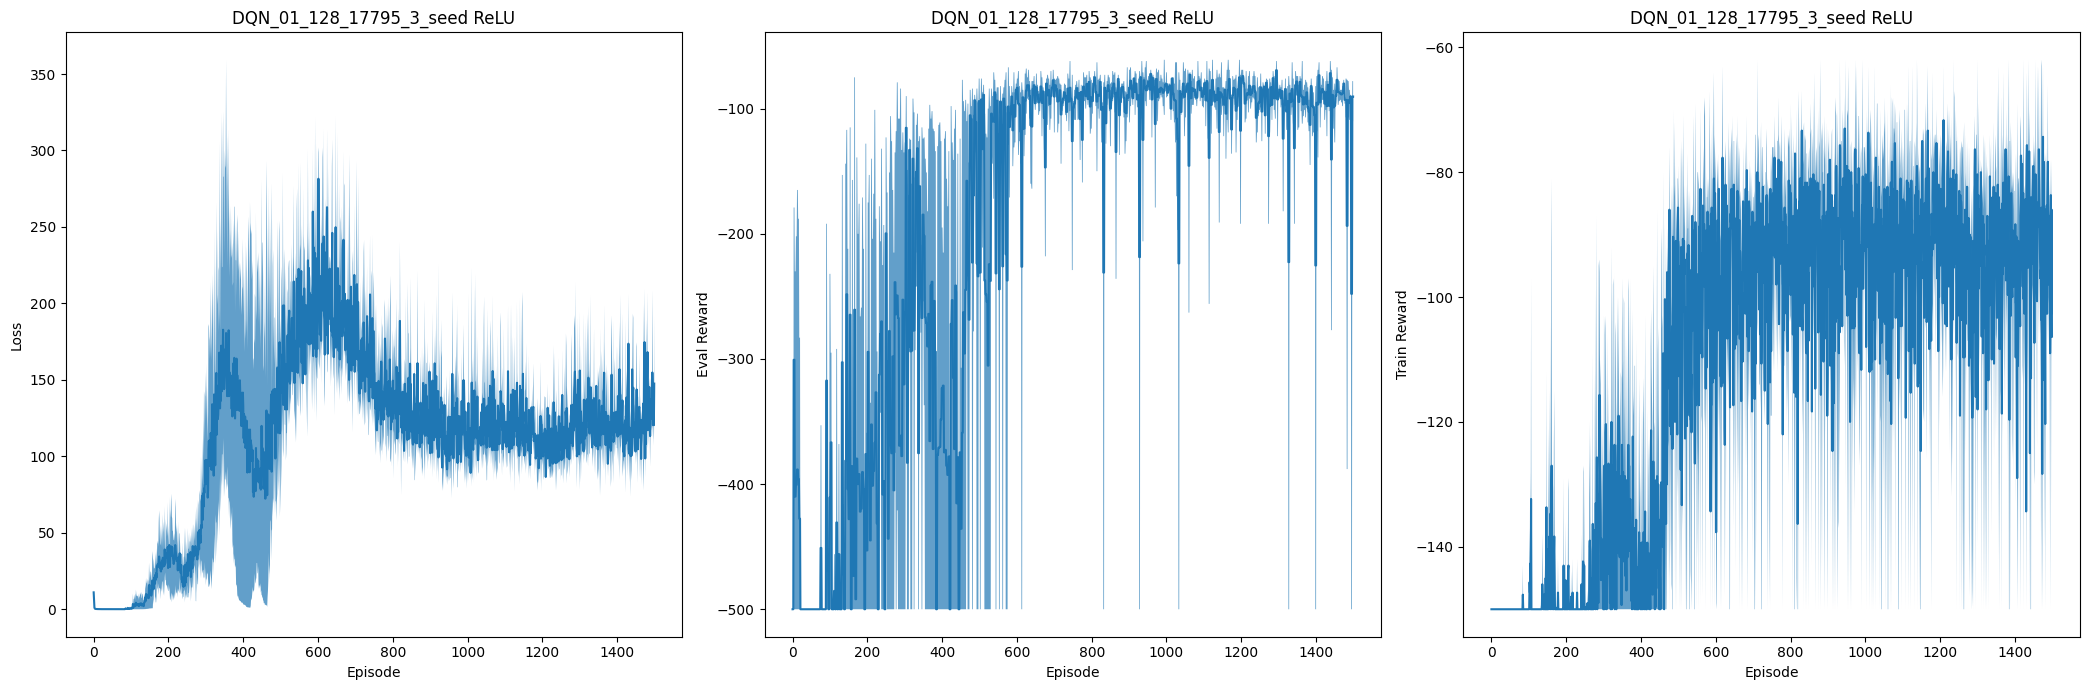

In [ ]:
for i, network in enumerate(networks[:4]):

    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]}_3_seed ‌ReLU")
    ax[1].set_title(f"{netwrok_names[i]}_3_seed ‌‌ReLU")
    ax[2].set_title(f"{netwrok_names[i]}_3_seed ‌‌ReLU")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()

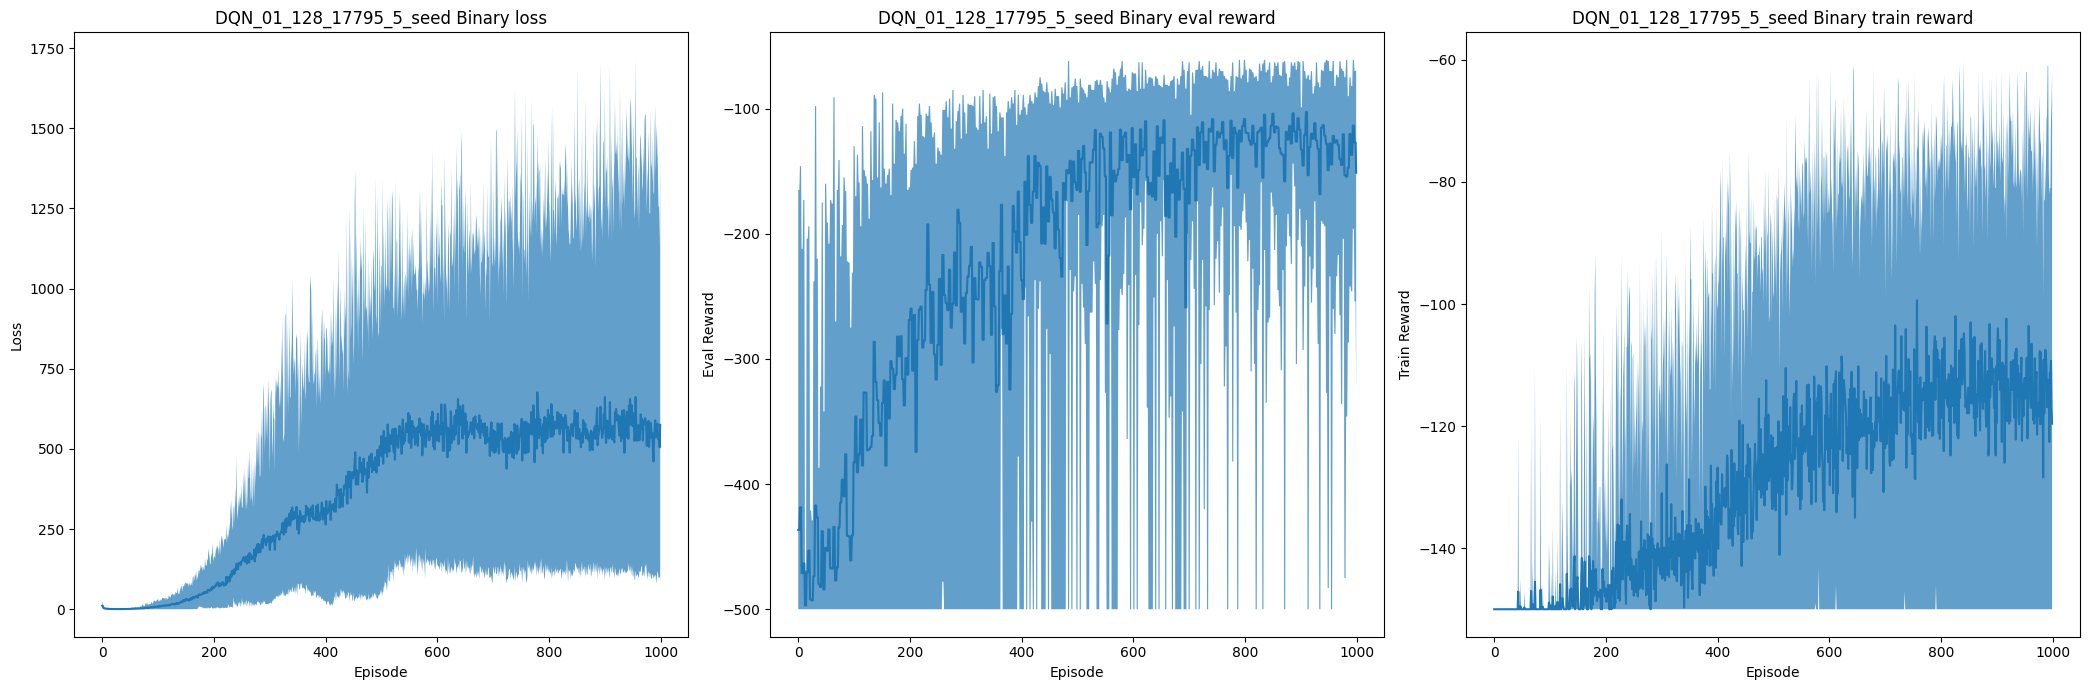

In [ ]:
for i, network in enumerate(networks[:4]):

    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]}_5_seed ‌Binary loss")
    ax[1].set_title(f"{netwrok_names[i]}_5_seed ‌Binary eval reward")
    ax[2].set_title(f"{netwrok_names[i]}_5_seed ‌Binary train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()

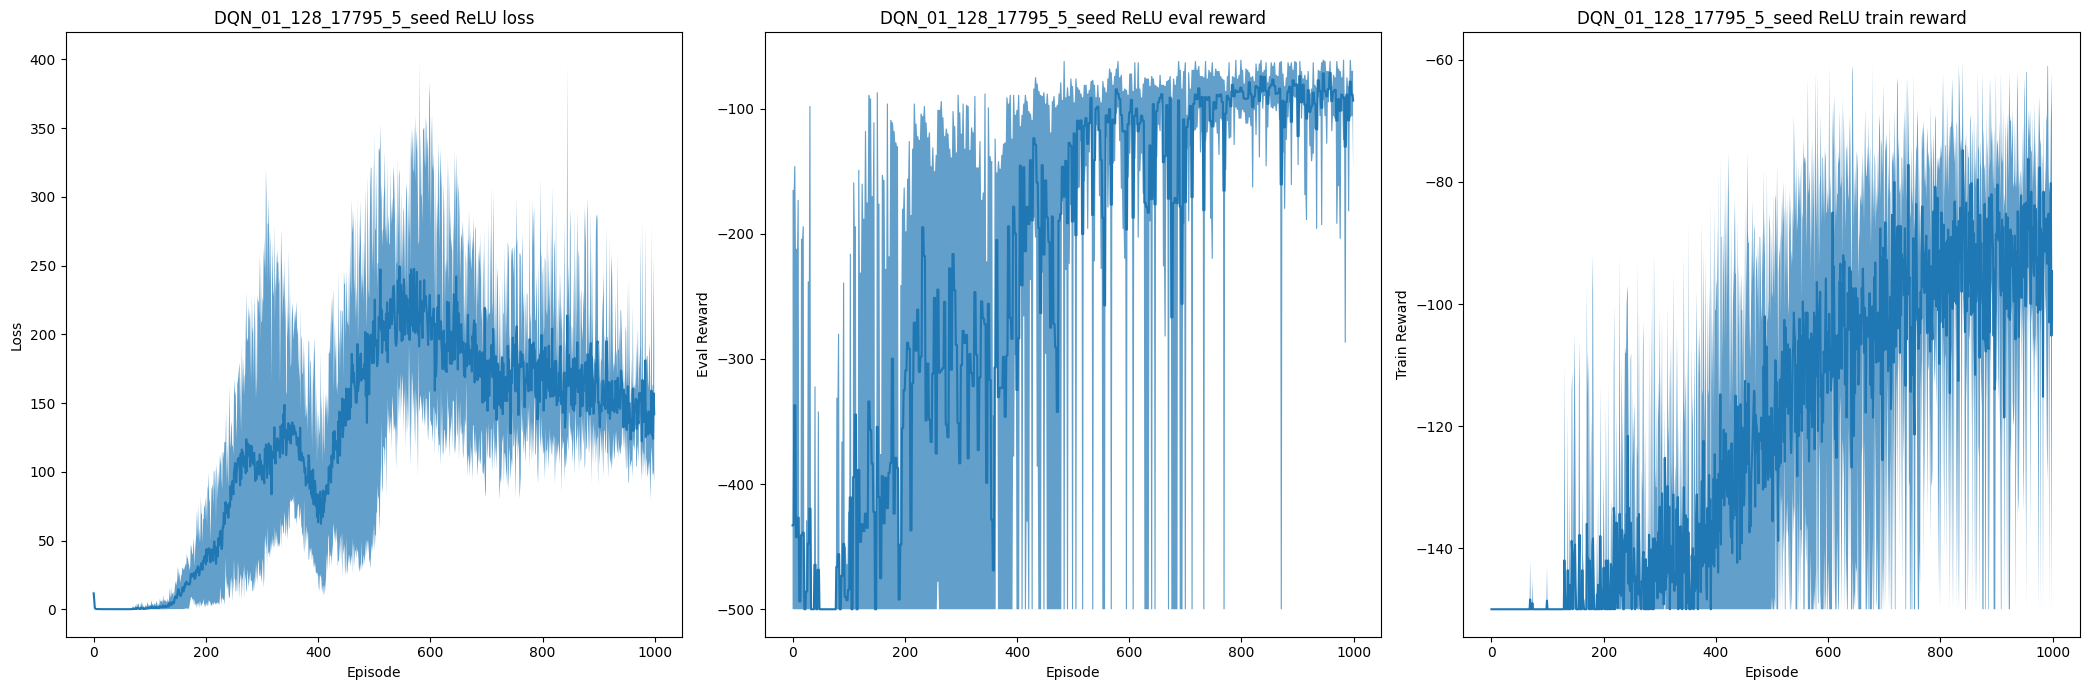

In [ ]:
for i, network in enumerate(networks[:4]):

    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]}_5_seed ReLU loss")
    ax[1].set_title(f"{netwrok_names[i]}_5_seed ReLU eval reward")
    ax[2].set_title(f"{netwrok_names[i]}_5_seed ReLU train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()

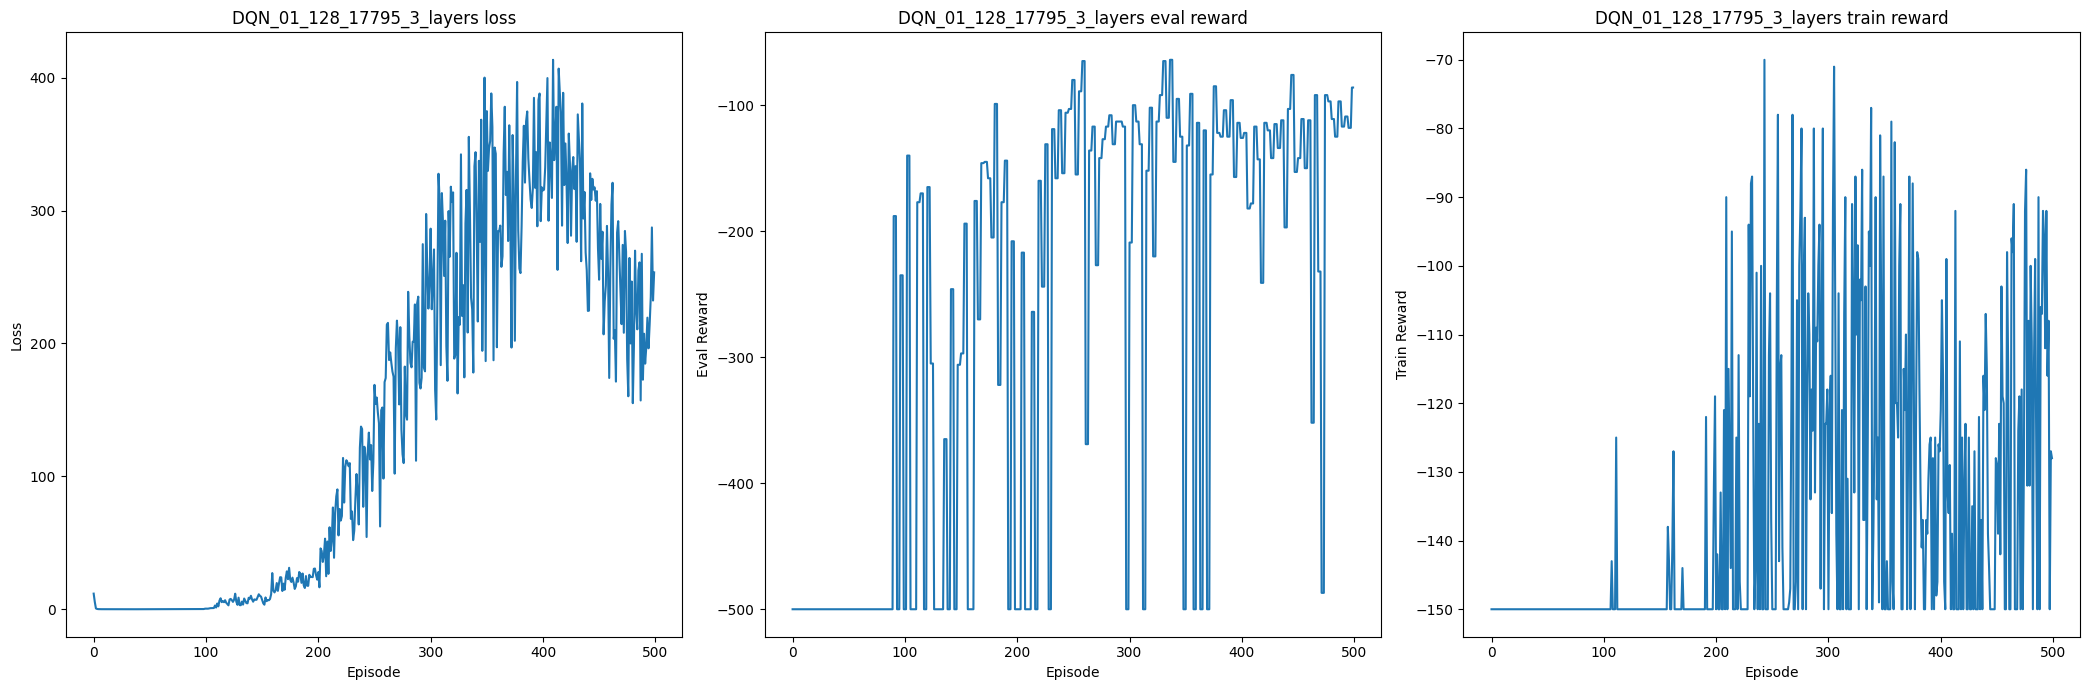

In [ ]:
for i, network in enumerate(networks[:4]):

    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]}_3_layers loss")
    ax[1].set_title(f"{netwrok_names[i]}_3_layers eval reward")
    ax[2].set_title(f"{netwrok_names[i]}_3_layers train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()

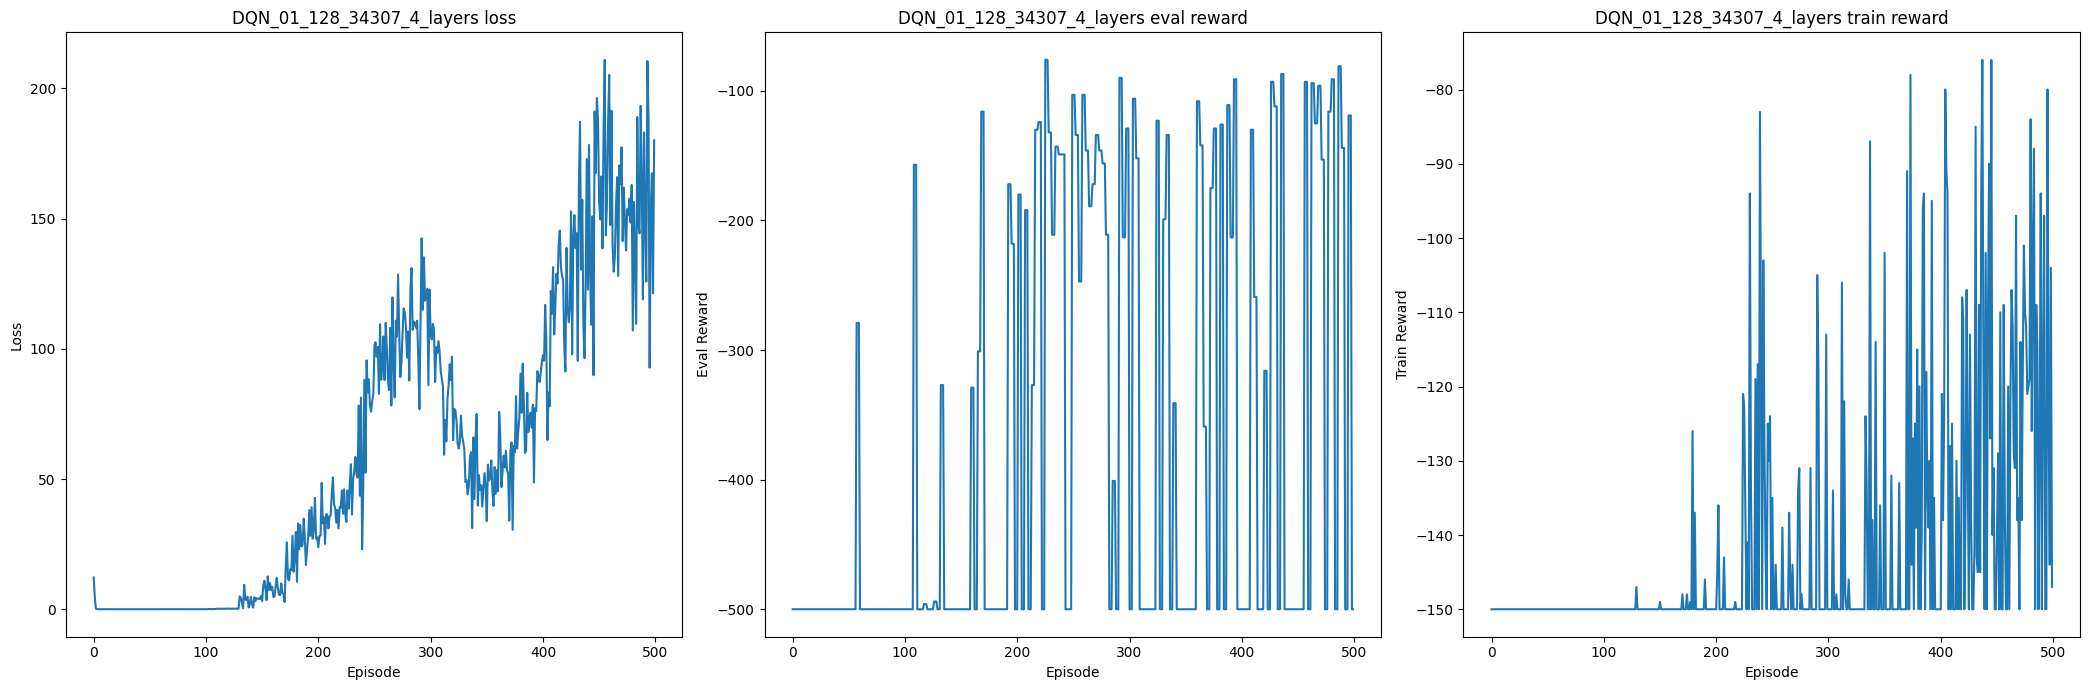

In [ ]:
for i, network in enumerate(networks[:4]):

    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]}_4_layers loss")
    ax[1].set_title(f"{netwrok_names[i]}_4_layers eval reward")
    ax[2].set_title(f"{netwrok_names[i]}_4_layers train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()

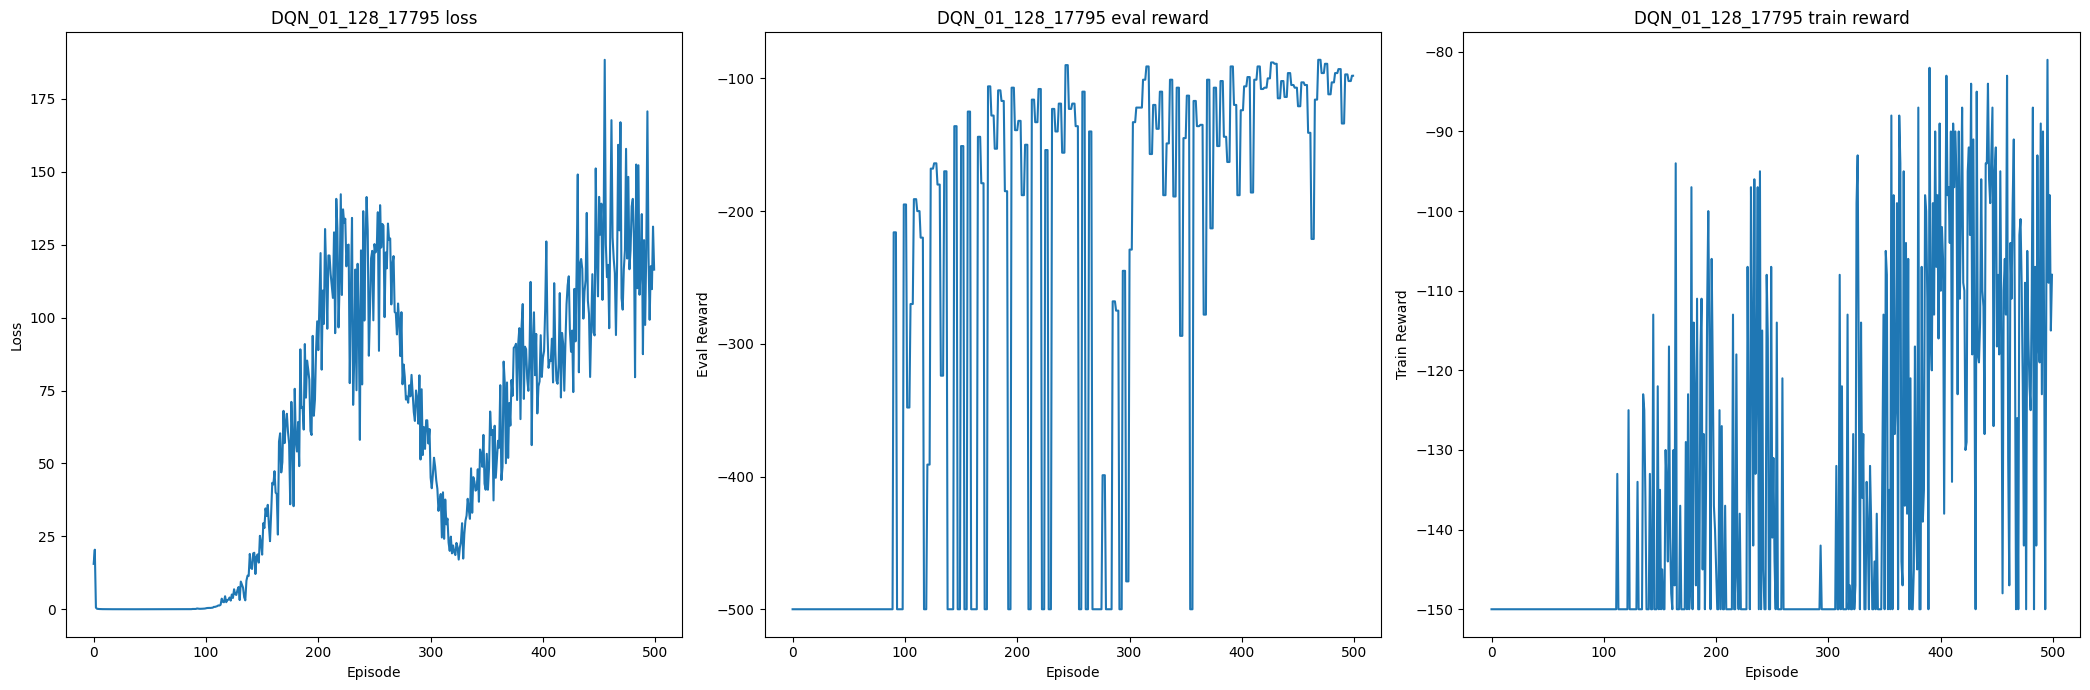

In [ ]:
for i, network in enumerate(networks[:4]):

    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]} loss")
    ax[1].set_title(f"{netwrok_names[i]} eval reward")
    ax[2].set_title(f"{netwrok_names[i]} train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()

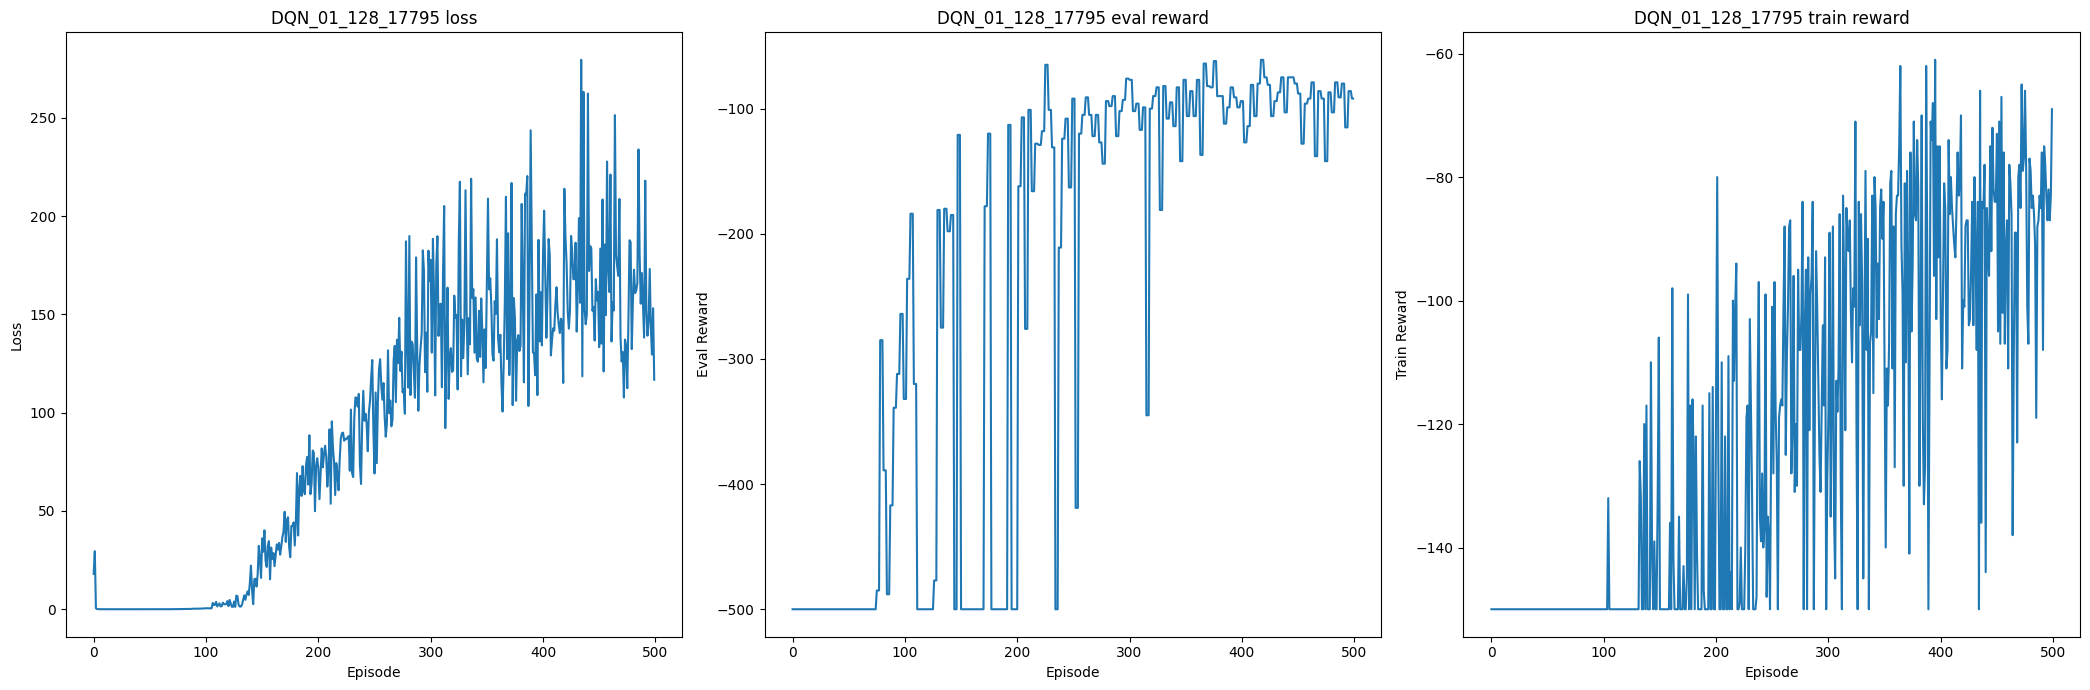

In [ ]:
for i, network in enumerate(networks[:4]):

    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]} loss")
    ax[1].set_title(f"{netwrok_names[i]} eval reward")
    ax[2].set_title(f"{netwrok_names[i]} train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()

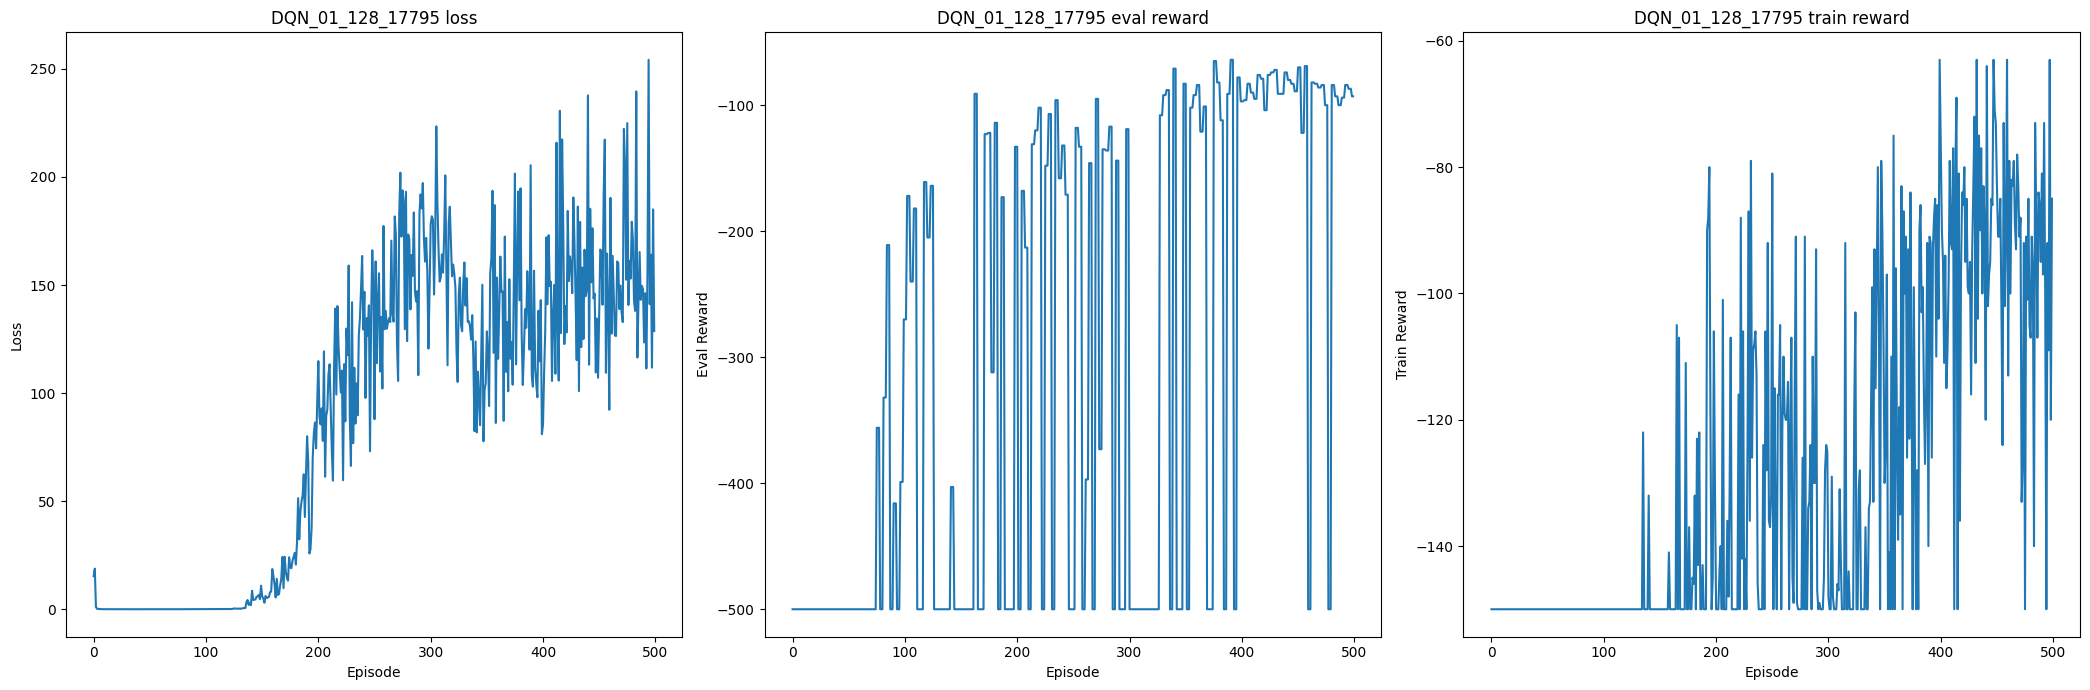

In [ ]:
for i, network in enumerate(networks[:4]):

    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = np.array([[0 if type(l) == int else l.cpu().detach().numpy() for l in loss] for loss in data[network]["loss"]])
    rewards = np.array([[l for l in reward] for reward in data[network]["train_reward"]])
    eval_rewards = np.array([[l for l in reward] for reward in data[network]["eval_reward"]])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.array(list(range(len(mean_loss))))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.array(list(range(len(mean_eval_reward))))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.array(list(range(len(mean_reward))))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{netwrok_names[i]} loss")
    ax[1].set_title(f"{netwrok_names[i]} eval reward")
    ax[2].set_title(f"{netwrok_names[i]} train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")
    plt.tight_layout()
    plt.show()